# G2Net Gravitational Wave Detection

## 1 - INTRO

### 1.1 - Loading and exploring the data

We'll first be attempting to load the data and go through the steps detailed here: https://www.gw-openscience.org/GW150914data/GW150914_tutorial.html to visualize a target signal

#### Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import scipy
import scipy.signal as signal
import glob
from matplotlib import mlab
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot

#### File load
The training_labels file contains a list of all signal files, as well as a flag indicating positives (1) or negatives (0).
The training and test files are contained in branching subtrees 16-wide (0-f)

In [2]:
%%time
train_labels = pd.read_csv('./input/training_labels.csv')
train_pathnames = glob.glob('./input/train/**/*.npy', recursive=True)
test_pathnames = glob.glob('./input/test/**/*.npy', recursive=True)
print(f"Dataset counts; train={len(train_pathnames)}, test={len(test_pathnames)}")
print(f"Training dataset value counts: \n{train_labels['target'].value_counts()}")
print(f"sample signal file name: {train_pathnames[0]}")

Dataset counts; train=560000, test=226000
Training dataset value counts: 
0    280070
1    279930
Name: target, dtype: int64
sample signal file name: ./input/train\0\0\0\00000e74ad.npy
Wall time: 3min 17s


Note that the training dataset has near 50% positive rate. Black hole mergers are extremely rare in real life, This data is all simulated. Our model needs to be able to account for this.

#### The npy files
These npy files contain 2-second (sampled at observations from 3 different observatories, LIGO Hanford, LIGO Livingston and VIRGO, sampled at 2,048 Hz

In [6]:
positive_index = train_labels[train_labels["target"]==1].index
negative_index = train_labels[train_labels["target"]==0].index
pd.DataFrame(np.load(train_pathnames[0])).rename(index={0: "LIGO H", 1: "LIGO L", 2: "VIRGO"})

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
LIGO H,-5.948305e-21,-5.849954e-21,-5.424152e-21,-5.372800e-21,-5.007260e-21,-4.926208e-21,-4.472056e-21,-4.381011e-21,-4.229612e-21,-4.114112e-21,...,-7.022800e-21,-6.918489e-21,-6.793697e-21,-6.529183e-21,-6.504904e-21,-6.596307e-21,-6.281353e-21,-6.066990e-21,-5.963457e-21,-5.757784e-21
LIGO L,9.754070e-22,4.525861e-22,4.586439e-23,-5.483304e-22,-6.569406e-22,-1.300912e-21,-1.796326e-21,-2.187243e-21,-2.682842e-21,-2.940782e-21,...,-9.543824e-21,-9.739959e-21,-1.004361e-20,-1.004674e-20,-1.022389e-20,-1.059154e-20,-1.065938e-20,-1.096082e-20,-1.097666e-20,-1.108581e-20
VIRGO,-1.748720e-21,-1.182868e-21,-1.932238e-21,-1.667348e-21,-1.616982e-21,-1.708056e-21,-1.362734e-21,-1.657147e-21,-1.272931e-21,-1.488557e-21,...,1.694580e-21,2.001893e-21,1.765994e-21,2.014835e-21,2.096212e-21,1.957340e-21,1.766527e-21,1.465023e-21,2.186449e-21,1.540859e-21


#### Visualizing
Let's look at one negative and one positive together. We'll transpose the dataframes for plotting, and plot both the raw data and its fourier transform (showing the amplitude as a function of frequency)

In [10]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=['Positive','Negative'])

positive = pd.DataFrame(np.load(train_pathnames[positive_index[0]])).rename(index={0: "LIGO H", 1: "LIGO L", 2: "VIRGO"}).transpose()
pos_subfig = px.line(positive, title=train_labels.iloc[[positive_index[0]]].id.item())
for i, v in enumerate(pos_subfig.data):
    fig.add_trace(go.Scatter(x=v['x'], y=v['y'], name = v['name'], line=dict(color=px.colors.qualitative.Plotly[i])), row=1, col=1)
    
negative = pd.DataFrame(np.load(train_pathnames[negative_index[0]])).rename(index={0: "LIGO H", 1: "LIGO L", 2: "VIRGO"}).transpose()
neg_subfig = px.line(negative, title=train_labels.iloc[[negative_index[0]]].id.item())
for i, v in enumerate(neg_subfig.data):
    fig.add_trace(go.Scatter(x=v['x'], y=v['y'], name = v['name'], line=dict(color=px.colors.qualitative.Plotly[i])), row=2, col=1)
    
fig.show()

We'll be using the purpose-built [GWpy](https://gwpy.github.io/docs/latest/index.html) libraries for the rest of this.
The frequency ranges used are lifted from [here](https://www.gw-openscience.org/GW150914data/LOSC_Event_tutorial_GW150914.html). Note that that link has data with frequency ranges > 1000, whereas we do not. It appears that merger events occur in the 30 to 500 band, wo this should not be an issue ![GW150914](https://www.gw-openscience.org/GW150914data/P150914/fig1-freqtime-H.png)

In [8]:
def read_file(fname):
    data = np.load(fname)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

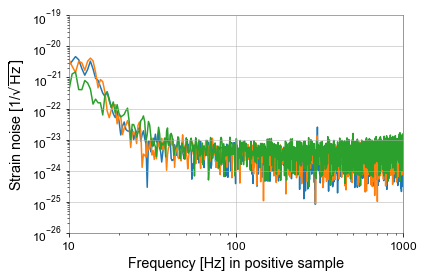

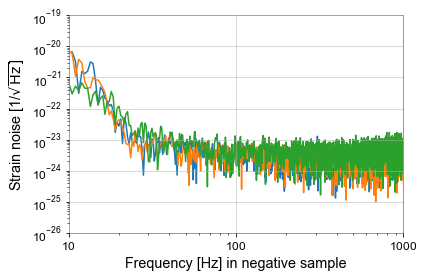

In [15]:
#Calculate ASD (Amplitude Spectral Densities)
pos1, pos2, pos3 = read_file(train_pathnames[positive_index[0]])
asd_pos_1 = pos1.asd(fftlength=2)
asd_pos_2 = pos2.asd(fftlength=2)
asd_pos_3 = pos3.asd(fftlength=2)
plot = Plot()
ax = plot.gca(xscale='log', xlim=(10, 1000), xlabel='Frequency [Hz] in positive sample',
              yscale='log', ylim=(1e-26, 1e-19),
              ylabel=r'Strain noise [1/$\sqrt{\mathrm{Hz}}$]')
lines = ax.plot(asd_pos_1, asd_pos_2, asd_pos_3) 

neg1, neg2, neg3 = read_file(train_pathnames[negative_index[0]])
asd_neg_1 = neg1.asd(fftlength=2)
asd_neg_2 = neg2.asd(fftlength=2)
asd_neg_3 = neg3.asd(fftlength=2)
plot = Plot()
ax = plot.gca(xscale='log', xlim=(10, 1000), xlabel='Frequency [Hz] in negative sample',
              yscale='log', ylim=(1e-26, 1e-19),
              ylabel=r'Strain noise [1/$\sqrt{\mathrm{Hz}}$]')
lines = ax.plot(asd_neg_1, asd_neg_2, asd_neg_3)

Nothing really stands out, as we'd expect, the signal is dominated by noise which will require some pre-processing to remove. The competition mentions the use of Q-transform, but [this research source](https://inspirehep.net/files/b2372ffedccfa26c93e8adbb14e6208c) mentions windowing, whitening and bandpassing.
For now we'll try and recreate the transformations detailed [here](https://www.gw-openscience.org/GW150914data/LOSC_Event_tutorial_GW150914.html).

In [38]:
#windowing data alpha as defined in https://mybinder.org/v2/gh/losc-tutorial/Data_Guide/master?filepath=Guide_Notebook.ipynb
NFFT = 2*2048 #2 seconds at 2048 Hz
window = scipy.signal.tukey(NFFT, alpha=1./4)
#Used for bandpassing.
#In the examples provided frequencies went from 43 to 400 or 800. We'll try 400 later.
fband = [40.0, 800.0] 
#whitening and bandpassing
def whiten_window_and_bandpass(ts1, ts2, ts3):
    ts1, ts2, ts3 = ts1*window, ts2*window, ts3*window
    ts1_prepped = ts1.whiten().bandpass(fband[0], fband[1])
    ts2_prepped = ts2.whiten().bandpass(fband[0], fband[1])
    ts3_prepped = ts3.whiten().bandpass(fband[0], fband[1])
    return ts1_prepped, ts2_prepped, ts3_prepped

In [37]:
whiten_window_and_bandpass(pos1, pos2, pos3)


 


(<TimeSeries([-0.00593743, -0.0987282 , -0.07333669, ...,
              -0.10784156, -0.18708003, -0.00543623]
             unit=Unit(dimensionless),
             t0=<Quantity 0. s>,
             dt=<Quantity 0.00048828 s>,
             name=None,
             channel=None)>,
 <TimeSeries([ 0.0066414 , -0.31316527, -0.160754  , ...,
               0.00988638,  0.08719867,  0.00357377]
             unit=Unit(dimensionless),
             t0=<Quantity 0. s>,
             dt=<Quantity 0.00048828 s>,
             name=None,
             channel=None)>,
 <TimeSeries([ 0.00585359, -0.08460758, -0.24198004, ...,
               0.21438096,  0.31223398,  0.02949162]
             unit=Unit(dimensionless),
             t0=<Quantity 0. s>,
             dt=<Quantity 0.00048828 s>,
             name=None,
             channel=None)>)